## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

In [27]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)



## transfer learning on MPI


In [67]:
# CNN on CAN
cnn_model_path="../../models/base_model/u_net_dist.h5"
cnn_model = tf.keras.models.load_model(cnn_model_path, custom_objects={'custom_rmse':custom_rmse})

can_data_path = "../../data/can_001"


def read_xarray_can(dir_name=""):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature mpi
    '''
    date="198201-201712"
  
    file_type ="CanESM2r1r10"
    #Chl_2D_mon_CanESM2r1r10_1x1_198201-201712.nc
        
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}_1x1_{date}.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}_1x1_{date}.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}_1x1_{date}.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}_1x1_{date}.nc')

    xco2 = xr.open_dataset(f'../../data/member_001/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}_1x1_{date}.nc')

    return chl,mld,sss,sst,xco2,pco2


chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)

chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)

def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr
        
pco2_socat_images = pco2_socat_preprocess(pco2.pCO2_socat.data)

dist_map = preprocess_image_reduced(dist_map)
    
X_tf = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
y_tf = pco2_socat_images
X_tf = X_tf.reshape((421,180,360,5),order='F')
# penalize smaller variance


In [47]:
np.min(pco2_socat_images), np.max(pco2_socat_images), np.var(pco2_socat_images)

(0.0, 2325.04931640625, 1272.746468982683)

In [40]:
# without transfer learning performance
y_tf=cnn_model.predict(X_tf)
#y_true,y_pred=inverse_scale_image(y_tf,pco2.pCO2.data)
custom_rmse(y_true,y_pred)


<tf.Tensor: shape=(), dtype=float32, numpy=926.1564>

In [48]:
# transfer learning
for layer in cnn_model.layers[:-8]:
    layer.trainable = False

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [49]:
from tensorflow.keras import backend as K

tf.keras.backend.clear_session()


def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    rmse1 = K.sqrt(K.mean(tf.math.squared_difference(y_pred1, y_true1),axis= -1))
    
    #y_pred2 = tf.boolean_mask(y_pred,idx2)
    #loss2 = 10*(K.var(y_true1)/K.var(y_pred2))
    #loss2 = tf.cast(loss2, y_pred.dtype)
    
    return rmse1


myLearnRate=0.0001

cnn_model.compile(
    loss=custom_rmse2, optimizer=keras.optimizers.Adam(learning_rate=myLearnRate),
)

model_path="../../models/transfer_CNN_can.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = cnn_model.fit(X_tf,y_tf, epochs=200, 
                         validation_data=(X_tf,y_tf),
                         workers=-1,batch_size=32,
                         callbacks=callbacks)

Epoch 1/200
14/14 [==============================] - 4s 281ms/step - loss: 285.8160 - val_loss: 268.5566
Epoch 2/200
14/14 [==============================] - 3s 225ms/step - loss: 268.2690 - val_loss: 246.8997
Epoch 3/200
14/14 [==============================] - 3s 226ms/step - loss: 239.0135 - val_loss: 202.3315
Epoch 4/200
14/14 [==============================] - 3s 227ms/step - loss: 178.6202 - val_loss: 139.2522
Epoch 5/200
14/14 [==============================] - 3s 225ms/step - loss: 124.4283 - val_loss: 120.7972
Epoch 6/200
14/14 [==============================] - 3s 227ms/step - loss: 110.4290 - val_loss: 107.6329
Epoch 7/200
14/14 [==============================] - 3s 225ms/step - loss: 99.7111 - val_loss: 95.3005
Epoch 8/200
14/14 [==============================] - 3s 225ms/step - loss: 92.2052 - val_loss: 87.7959
Epoch 9/200
14/14 [==============================] - 3s 226ms/step - loss: 88.9542 - val_loss: 81.7623
Epoch 10/200
14/14 [==============================] - 3s 225m

In [53]:
#cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_2.h5', custom_objects={'custom_rmse':custom_rmse})
cnn_model = tf.keras.models.load_model('../../models/transfer_CNN_can.h5', custom_objects={'custom_rmse2':custom_rmse2})


predicted_image = cnn_model.predict(X_tf,verbose=1)

chl,mld,sss,sst,xco2,pco2 = read_xarray_can(can_data_path)
coord = (pco2.pCO2.data==0.0)
predicted_image[coord] = 0

full_truth = pco2.pCO2.data
full_truth[coord] = 0

14/14 [==============================] - 1s 71ms/step


In [63]:
custom_rmse(predicted_image,full_truth)

<tf.Tensor: shape=(), dtype=float32, numpy=63.423462>

In [68]:
X_index=np.lib.stride_tricks.sliding_window_view(range(421),3)
X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X = X.reshape((421,180,360,6),order='F')
X = X[X_index][:-1]

y_tf=np.expand_dims(y_tf[X_index][1:],axis=4)

In [69]:
X.shape, y_tf.shape # changed sliding

((418, 3, 180, 360, 6), (418, 3, 180, 360, 1))

In [70]:
tf.keras.backend.clear_session()

convlstm_model_path = "../../models/ConvLSTM_with_pco2.h5"
convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})


for layer in convlstm_model.layers[:-2]:
    layer.trainable = False

convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [71]:
convlstm_model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
)

model_path="../../models/transfer_CNN_LSTM_can.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 16

In [72]:
history = convlstm_model.fit(
    X,
    y_tf,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X, y_tf),
    callbacks=callbacks,
)

Epoch 1/50
27/27 [==============================] - 45s 2s/step - loss: 75.6816 - val_loss: 48.9882
Epoch 2/50
27/27 [==============================] - 38s 1s/step - loss: 50.9764 - val_loss: 42.7980
Epoch 3/50
27/27 [==============================] - 38s 1s/step - loss: 45.0459 - val_loss: 40.9656
Epoch 4/50
27/27 [==============================] - 38s 1s/step - loss: 43.7920 - val_loss: 39.6410
Epoch 5/50
27/27 [==============================] - 38s 1s/step - loss: 41.9055 - val_loss: 38.7024
Epoch 6/50
27/27 [==============================] - 38s 1s/step - loss: 41.5925 - val_loss: 37.7057
Epoch 7/50
27/27 [==============================] - 38s 1s/step - loss: 40.5759 - val_loss: 37.1354
Epoch 8/50
27/27 [==============================] - 38s 1s/step - loss: 39.0827 - val_loss: 37.4574
Epoch 9/50
27/27 [==============================] - 38s 1s/step - loss: 38.9366 - val_loss: 36.2424
Epoch 10/50
27/27 [==============================] - 38s 1s/step - loss: 38.3275 - val_loss: 36.0261

In [75]:
chl,mld,sss,sst,xco2,pco2t2 = read_xarray_can(can_data_path)

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])
y_true_full = np.expand_dims(tmp,axis=4)
y_true_full.shape

coord = (y_true_full==0.0)


In [76]:
tf_model = tf.keras.models.load_model("../../models/transfer_CNN_LSTM_can.h5", custom_objects={'custom_rmse':custom_rmse})

predicted_frames= tf_model.predict(X,verbose=1)
predicted_frames[coord] = 0

print("Full RMSE score:")
a=custom_rmse(predicted_frames[:,1:2],y_true_full[:,1:2])
print(a)


14/14 [==============================] - 28s 1s/step
Full RMSE score:
tf.Tensor(47.465065, shape=(), dtype=float32)


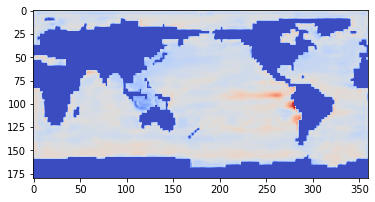

In [77]:
norm = mcolors.Normalize(vmin=0, vmax = 750)


img=plt.imshow(np.flipud(predicted_frames[0,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
plt.colorbar(img,ax=axis)

### GIF generation

In [65]:
# gif generation for cnn

import matplotlib.colors as mcolors
import imageio

# chl,mld,sss,sst,xco2,pco2 = read_xarray_can(mpi_data_path)
# full_truth = pco2.pCO2.data
# full_truth[coord] = 0

norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(421):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_image[i]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(full_truth[i]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(full_truth[i]-(predicted_image[i])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(np.sqrt(np.mean((full_truth[i]-predicted_image[i])**2)),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/cnn_can_transfer.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)



In [78]:
# gif generation for conv-lstm

norm = mcolors.Normalize(vmin=0, vmax = 750)
norm2 = mcolors.TwoSlopeNorm(vmin=-500, vmax = 500, vcenter=0)


filenames = []

for i in range(418):
    figure, axis = plt.subplots(1, 3,figsize=(18, 10))
    
    img=axis[0].imshow(np.flipud(predicted_frames[i,1:2][0]),cmap="coolwarm", interpolation="nearest", norm=norm)
    axis[0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[1].imshow(np.flipud(y_true_full[i,1:2][0]),cmap="coolwarm", interpolation="nearest",norm=norm)
    axis[1].set_title("true")

    img2=axis[2].imshow(np.flipud(y_true_full[i,1:2][0]-(predicted_frames[i,1:2][0])),cmap="RdBu", norm=norm2)
    axis[2].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    text = "rmse: "+str(np.round(np.sqrt(np.mean((y_true_full[i,1:2][0]-predicted_frames[i,1:2][0])**2)),2))
    plt.text(-60, -60, text, fontsize = 20)
    
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/convlstm_can_transfer.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)



In [ ]:
def inverse_scale_frame_socat(arr,df, X_index=[]):
    """
    inverse_scale_frame(arr, df):
    - inverses the pco2 scaling
    """
    old_min = 0
    df_tmp = df[df!=0.0]
    old_max = np.nanmax(df_tmp)
    y_pred = arr*(old_max-old_min)/255+old_min
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

